In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('fivethirtyeight')

### Load Sensor Data
- Load data from disk
- Shrink values of samples for readability
- Assert number of samples per second equals to 100
- Split data to training set and stream set

In [2]:
sensor = pd.read_csv("sensor-27minutes.csv", 
                      date_parser=pd.to_datetime, 
                      parse_dates=['Time'], index_col=0, squeeze=True) * 0.001 # work with lower numbers


In [3]:
print("Count Numbers of Samples Per Second\n", sensor.resample('S').apply(list).apply(len).value_counts(), sep='')
# all seconds have 100 samples except the last one
# drop last observation for consistency
sensor = sensor.iloc[:-1]

Count Numbers of Samples Per Second
100    1620
1         1
dtype: int64


In [4]:
# split in training and stream
sensor_data = sensor[sensor.index.minute.isin(np.arange(19, 39))]  
sensor_stream = sensor[sensor.index.minute.isin(np.arange(39, 46))]  

### Apply  Low Pass Filter On Stream Data

#### Requirements.
- T = 1.0    |       Sample Period
- fs = 100.0   |     sample rate, Hz
- cutoff = 7    |    desired cutoff frequency of the filter, Hz
- nyq = 0.50 * fs |  Nyquist Frequency
- order = 2        | sin wave can be approx represented 
- n = int(T * fs)   | total number of samples

In [5]:
# Butter Filter Construction
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff=3, fs=100, order=2, nyq_coef=0.50):
    nyq = nyq_coef * fs
    normal_cutoff = cutoff / nyq 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def plot_signal_comparison(raw, filtered):
    plt.figure(figsize=(14, 4))
    plt.plot(np.arange(len(raw)), raw.values, label='Raw')
    plt.plot(np.arange(len(filtered)), filtered.values, label='Filter')
    plt.ylabel("Signal")
    plt.xlabel("Sample")
    plt.title(f"Raw-Filtered Signal Comparison")
    plt.legend()
    plt.show();
    
sensor_data_filtered = pd.Series(butter_lowpass_filter(sensor_data), 
                                 index=sensor_data.index,
                                 name="sensor_filtered")

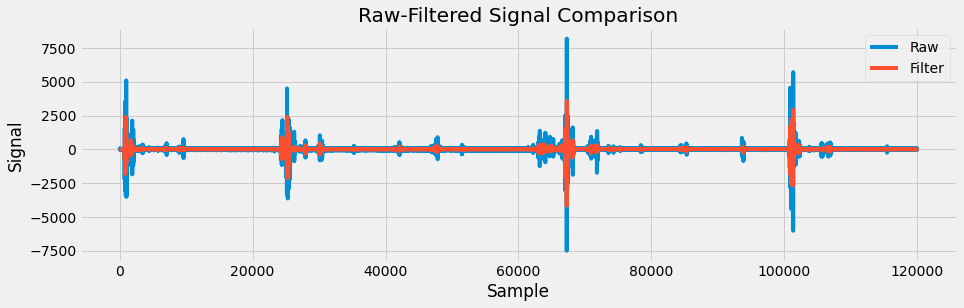

In [6]:
plot_signal_comparison(sensor_data, sensor_data_filtered)
# plot_signal_comparison(sensor_data.iloc[:40000], sensor_data_filtered.iloc[:40000])

### Detect & Replace Outliers
- Detect outliers with Isolation Forest
- Plot Result
- Remove Outliers
- Replace Ouliers using a linear method

In [7]:
from sklearn.ensemble import IsolationForest

outlier_model = (IsolationForest(n_estimators=1000, contamination='auto', n_jobs=-1, verbose=True, random_state=0).
                 fit(sensor_data_filtered.values.reshape(-1,1)))

outlier_pred = outlier_model.predict(sensor_data_filtered.values.reshape(-1,1))

is_outlier = np.asarray([i == -1 for i in outlier_pred])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    3.6s remaining:   18.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    3.8s finished


In [8]:
print("Outlier Detection Results\n-------------------------\nStd without outliers: {:5.2f}\nStd with outliers: {:8.2f}".format(
    sensor_data_filtered[is_outlier == False].std(), 
    sensor_data_filtered.std()))
print("\nOutlier Percentage: {:1.2%}".format(is_outlier.mean()))

Outlier Detection Results
-------------------------
Std without outliers:  6.26
Std with outliers:   129.26

Outlier Percentage: 8.01%


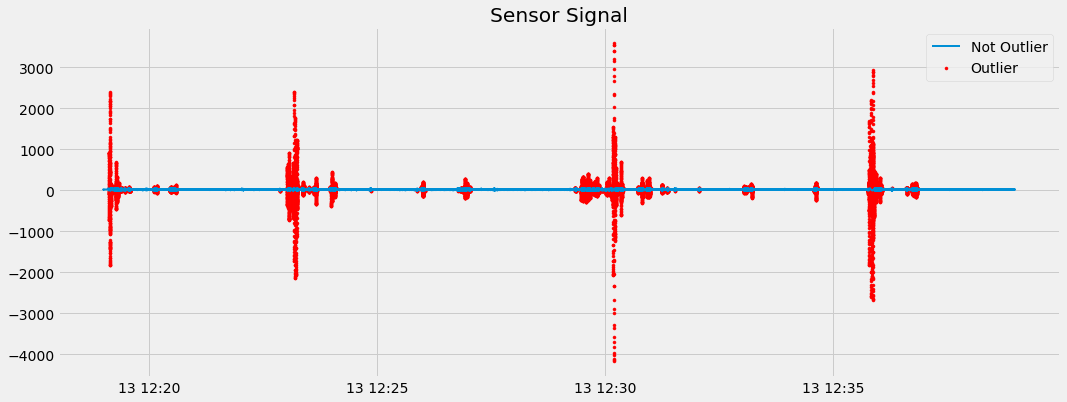

In [9]:
plt.figure(figsize=(16,6))
plt.plot(sensor_data_filtered[is_outlier == False], lw=2, label='Not Outlier')
plt.scatter(sensor_data_filtered[is_outlier].index, 
            sensor_data_filtered[is_outlier].values,
            marker='.',
            c='red',
            label='Outlier')
plt.legend()
plt.title("Sensor Signal");

In [10]:
# Remove Outliers
print("Std before Outlier Removal:", sensor_data_filtered.std())
sensor_data_filtered[is_outlier] = np.nan
print("Number of Samples Removed:", sensor_data_filtered.isna().sum())
print("Std after Outlier Removal:", sensor_data_filtered.std())
# Replace Outliers Linearly
sensor_data_filtered = sensor_data_filtered.interpolate()
print("Std after Outlier Replacement:", sensor_data_filtered.std())

Std before Outlier Removal: 129.26098972495396
Number of Samples Removed: 9614
Std after Outlier Removal: 6.260986684972508
Std after Outlier Replacement: 8.51809190734162


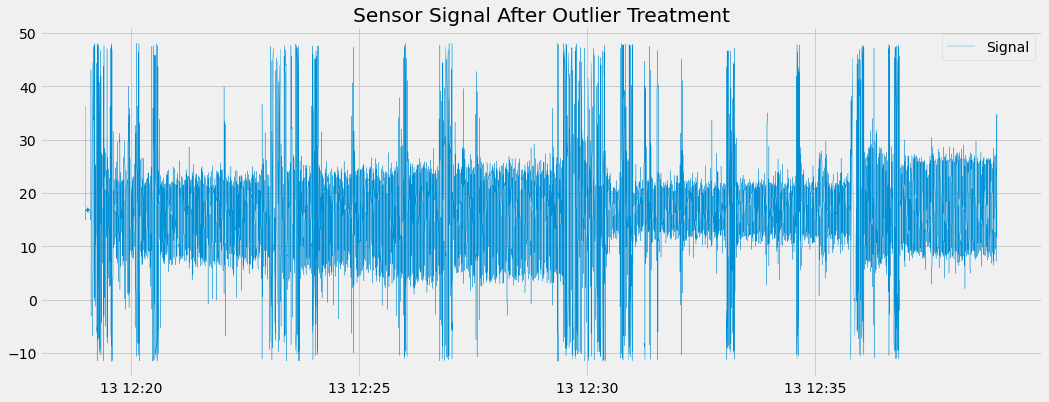

In [11]:
plt.figure(figsize=(16,6))
plt.plot(sensor_data_filtered[is_outlier == False], lw=0.33, label='Signal')
plt.legend()
plt.title("Sensor Signal After Outlier Treatment");

### Envelope Extraction
- find local minimums
- find local maximums
- find and return their index

In [12]:
def extract_envelopes_idx(s):      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1    
    lmin = lmin[[i + np.argmin(s[lmin[i: i+1]]) for i in range(0, len(lmin))]]
    lmax = lmax[[i + np.argmax(s[lmax[i: i+1]]) for i in range(0, len(lmax))]]  
    return lmin.tolist(), lmax.tolist()

In [13]:
lmin, lmax = extract_envelopes_idx(sensor_data_filtered)

In [14]:
print("n_local Min: {:8,}\nn_local Max: {:8,}\nn_samples: {:10,}".format(len(lmin), len(lmax),len(sensor_data_filtered)))

n_local Min:    5,511
n_local Max:    5,510
n_samples:    120,000


### Sensor Dataframe
- Pass the sensor data and the envelope features into a dataframe
- Calculate and pass the derivatives to indicate the direction of the signal
- Example plot derivatives' autocorrelation

In [15]:
idx_in_second = np.arange(len(sensor_data_filtered)) % 100    # index of a sample in a second
sensor_df = pd.DataFrame({'minute':sensor_data_filtered.index.minute,
                          'second':sensor_data_filtered.index.second})
sensor_df['idx_in_second'] = idx_in_second
sensor_df['signal'] = sensor_data_filtered.values
sensor_df['is_lmax'] = 0.0
sensor_df['is_lmin'] = 0.0
sensor_df.loc[lmin, "is_lmin"] = 1.0
sensor_df.loc[lmax, "is_lmax"] = 1.0
sensor_df['is_peak'] = ((sensor_df.is_lmax > 0) | (sensor_df.is_lmin > 0)).map({True:1, False:0})
sensor_df['diff1'] = sensor_df.signal.diff()
sensor_df['diff2'] = sensor_df.diff1.diff()

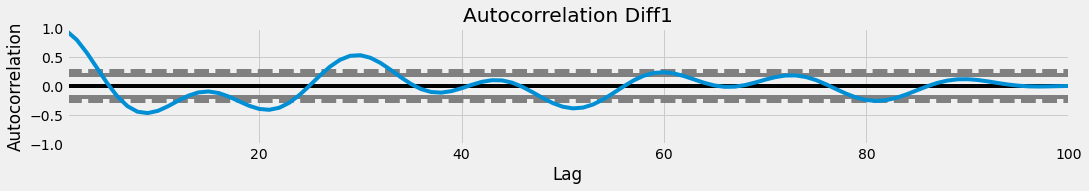

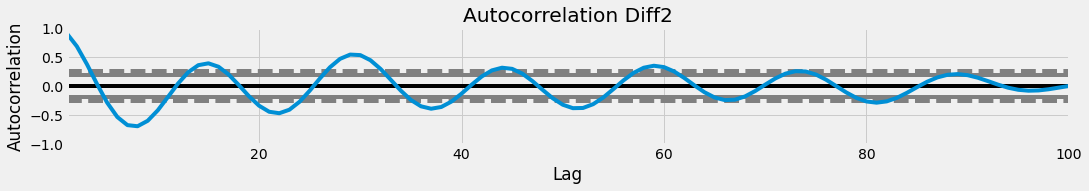

In [16]:
# Autocorrelation derivatives plot for a minute and a second (example)
from pandas.plotting import autocorrelation_plot
minute, second = 20, 0 # select here minute and second to plot
s1 = sensor_df[(sensor_df.minute==minute) & (sensor_df.second==second)].set_index("idx_in_second")["diff1"].dropna()
s2 = sensor_df[(sensor_df.minute==minute) & (sensor_df.second==second)].set_index("idx_in_second")["diff2"].dropna()

plt.figure(figsize=(16, 2))
autocorrelation_plot(s1)
plt.grid(True)
plt.title("Autocorrelation Diff1");
plt.figure(figsize=(16, 2))
autocorrelation_plot(s2)
plt.grid(True)
plt.title("Autocorrelation Diff2");

### Decompose Signal
- Implement Variational mode decomposition 
- Pass decompoded modes and spectra of the modes in the sensor df
- Also pass the moving averages of 1 second (100 samples)

In [17]:
!pip install vmdpy

In [18]:
from vmdpy import VMD  

#parameters for VMD  
alpha = 2000       # bandwidth constraint  
tau = 0.           # noise-tolerance (no strict fidelity enforcement)  
K = 3              # 3 modes  
DC = 0             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-7  

# Decompose  
u, u_hat, omega = VMD(sensor_df.signal, alpha, tau, K, DC, init, tol)  

In [19]:
# Pass data
u_hat = pd.DataFrame(u_hat, columns=["u_hat1", "u_hat2", "u_hat3"], index=sensor_df.index)
sensor_df = sensor_df.join(u_hat)
sensor_df['u1'] = u[0]
sensor_df['u2'] = u[1]
sensor_df['u3'] = u[2]

In [20]:
sensor_df['signal_ma100'] = sensor_df.signal.rolling(100).mean()

### Load Labels
- Load Labels data
- Resample labels per second
- Keep only the labels needed
- Split in training data and stream 

In [21]:
labels = pd.read_excel(
    io="label-27minutes.xlsx",
    nrows=1749,
    usecols="S,D,H,R,Calculated time".split(','),
    parse_dates=["Calculated time"],
    date_parser=pd.to_datetime,
    index_col="Calculated time"
    )

In [22]:
labels_data = labels[labels.index.minute.isin(np.arange(19, 39))].resample('S').mean()
labels_stream = labels[labels.index.minute.isin(np.arange(39, 46))].resample('S').mean()

### Prepare Training Dataset
- Manipulate dataframes to provide training per second.
- Split training data in train and validation sets

In [23]:
# Insert the datetime index into the sensor
sensor_df.index = sensor_data_filtered.index

In [24]:
df = sensor_df.join(labels_data).drop(columns=["u_hat1", "u_hat2", "u_hat3"])

In [25]:
sensor_df_resampled = sensor_df.resample('S').apply(list)

In [26]:
sensor_df_resampled.head(1)

,minute,second,idx_in_second,signal,is_lmax,is_lmin,is_peak,diff1,diff2,u_hat1,u_hat2,u_hat3,u1,u2,u3,signal_ma100
Time,,,,,,,,,,,,,,,,
2020-11-13 12:19:00,"[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[36.27180810689252, 33.41231235699823, 30.6423...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[nan, -2.8594957498942932, -2.769985410188042,...","[nan, nan, 0.08951033970625133, 0.156677195242...",[(-0.18140964955902883+3.907985046680551e-14j)...,"[(1.2012348045207082-1.1901590823981678e-13j),...","[(0.6589991782967919-8.881784197001252e-14j), ...","[19.51259367961781, 19.432417185966436, 19.309...","[6.04505467100502, 5.866260643123159, 5.558105...","[6.466507176066007, 6.01653750031581, 5.201972...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [27]:
reshape_value = sensor_df_resampled.shape[0], 100  # calculate reshape

In [28]:
samples = pd.DataFrame(sensor_df_resampled['signal'].explode().values.reshape(reshape_value), 
                       columns=["sample{}".format(i) for i in range(1, reshape_value[1]+1)],
                       index = sensor_df_resampled.index)

In [29]:
lmax = pd.DataFrame(sensor_df_resampled['is_lmax'].explode().values.reshape(reshape_value),
                     columns=["is_lmax{}".format(i) for i in range(1, reshape_value[1]+1)],
                     index = sensor_df_resampled.index) 
                         
lmin = pd.DataFrame(sensor_df_resampled['is_lmin'].explode().values.reshape(reshape_value),
                     columns=["is_lmin{}".format(i) for i in range(1, reshape_value[1]+1)],
                     index = sensor_df_resampled.index) 

peak = pd.DataFrame(sensor_df_resampled['is_peak'].explode().values.reshape(reshape_value),
                     columns=["is_peak{}".format(i) for i in range(1, reshape_value[1]+1)],
                     index = sensor_df_resampled.index) 

In [30]:
u1 = pd.DataFrame(sensor_df_resampled['u1'].explode().values.reshape(reshape_value),
                     columns=["u1{}".format(i) for i in range(1, reshape_value[1]+1)],
                     index = sensor_df_resampled.index) 

In [31]:
u2 = pd.DataFrame(sensor_df_resampled['u2'].explode().values.reshape(reshape_value),
                     columns=["u2{}".format(i) for i in range(1, reshape_value[1]+1)],
                     index = sensor_df_resampled.index) 

In [32]:
u3 = pd.DataFrame(sensor_df_resampled['u3'].explode().values.reshape(reshape_value),
                     columns=["u3{}".format(i) for i in range(1, reshape_value[1]+1)],
                     index = sensor_df_resampled.index) 

In [33]:
signal_ma100 = pd.DataFrame(sensor_df_resampled['signal_ma100'].explode().values.reshape(reshape_value),
                     columns=["signal_ma100_{}".format(i) for i in range(1, reshape_value[1]+1)],
                     index = sensor_df_resampled.index) 

In [34]:
diff1 = pd.DataFrame(sensor_df_resampled['diff1'].explode().values.reshape(reshape_value),
                     columns=["diff1_{}".format(i) for i in range(1, reshape_value[1]+1)],
                     index = sensor_df_resampled.index) 

In [35]:
diff2 = pd.DataFrame(sensor_df_resampled['diff2'].explode().values.reshape(reshape_value),
                     columns=["diff2_{}".format(i) for i in range(1, reshape_value[1]+1)],
                     index = sensor_df_resampled.index) 

In [36]:
df = samples.join([lmin, lmax, peak, diff1, diff2, u1, u2, u3, signal_ma100, labels_data]).astype(np.float32)

In [37]:
df['minute'] = df.index.minute
df['second'] = df.index.second
df['n_peaks_avg'] = sensor_df_resampled.is_peak.apply(np.average)

In [38]:
X, y = df.dropna().drop(columns=list("SDHR")), df.dropna()[list("SDHR")]
split_value = int(df.shape[0]*2/3) # split 2/3
X_train, X_valid, y_train, y_valid = X.iloc[:split_value], X.iloc[split_value:], y.iloc[:split_value], y.iloc[split_value:]

In [39]:
df.head(3)

,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10,...,signal_ma100_98,signal_ma100_99,signal_ma100_100,S,D,H,R,minute,second,n_peaks_avg
Time,,,,,,,,,,,,,,,,,,,,,
2020-11-13 12:19:00,36.271809,33.412312,30.642326,28.029018,25.638632,23.529339,21.741102,20.286158,19.143740,18.262445,...,NaN,NaN,17.485788,85.0,57.0,86.0,9.0,19,0,0.15
2020-11-13 12:19:01,16.897169,16.886831,16.843744,16.783915,16.727552,16.691671,16.685188,16.707935,16.752295,16.805973,...,16.810806,16.808981,16.806896,85.0,57.0,89.0,9.0,19,1,0.18
2020-11-13 12:19:02,16.720301,16.786098,16.836365,16.855684,16.840277,16.798336,16.746038,16.701353,16.678095,16.682716,...,16.808393,16.810030,16.810541,85.0,57.0,91.0,9.0,19,2,0.17


### Feature Selection with Linear Model
- Select features with lasso regression
- Use cross validation with k=5 to validate the parameters

In [40]:
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import mean_absolute_error

In [41]:
def select_features(X_train, y_train, X_valid=None, y_valid=None, cv=5, verbose=1):
    lasso = LassoLarsCV(max_iter=10000, normalize=True, verbose=verbose, cv=cv, n_jobs=-1, ).fit(X_train, y_train)
    feature_selection = X.columns[np.nonzero(lasso.coef_)[0].tolist()]
    print("MAE trainset:", mean_absolute_error(y_train, lasso.predict(X_train)))
    try:
        print("MAE validset:", mean_absolute_error(y_valid, lasso.predict(X_valid)))
    except:
        pass
    print("Feature Selection:", feature_selection)
    return feature_selection

In [42]:
feature_selection = {}
for target in "SDHR":
    print(f" Feature Selection {target} ".center(60, "="))
    feature_selection[target] = select_features(X_train, y_train[target], X_valid, y_valid[target])

=================== Feature Selection S ====================


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.4s finished


MAE trainset: 1.5397931011630568
MAE validset: 2.1130719142348338
Feature Selection: Index(['is_peak1', 'diff2_49', 'minute', 'second'], dtype='object')
=================== Feature Selection D ====================


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


MAE trainset: 0.7815795156795292
MAE validset: 1.0371501857970635
Feature Selection: Index(['is_peak1', 'diff2_49', 'minute', 'second'], dtype='object')
=================== Feature Selection H ====================


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.4s finished


MAE trainset: 4.178865625000001
MAE validset: 4.799623239436619
Feature Selection: Index([], dtype='object')
=================== Feature Selection R ====================


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.7s finished


MAE trainset: 0.9944687499999999
MAE validset: 1.2755862676056338
Feature Selection: Index([], dtype='object')


In [43]:
print("Average Validation MAE:", np.mean([2.1130719142348338,
                                          1.0371501857970635,
                                          4.799623239436619,  
                                          1.2755862676056338]))

Average Validation MAE: 2.306357901768538


### Add Polynomial Features
- Add 2nd degree polynomial features to feature selection to improve the result
- Train a Ridge and an ensemble model with cross-validation
- Calculate and compare Average Validation MAE
- Compare models

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV

In [45]:
pf = PolynomialFeatures(degree=2).fit(X_train[feature_selection['S']])

In [46]:
X_train_poly = pf.transform(X_train[feature_selection['S']]) # feature selection is the same for all targets
X_valid_poly = pf.transform(X_valid[feature_selection['S']])

In [47]:
ridge = RidgeCV(alphas=(0.01, 0.1, 0.5, 1, 2.5, 5, 7.5, 10), 
                normalize=True,
                cv=5)
ridge.fit(X_train_poly, y_train)
ridge_mae = mean_absolute_error(y_valid, ridge.predict(X_valid_poly), multioutput='raw_values')
print("MAE of S, D, H, R =", ridge_mae)
print("Average Validation MAE:", np.average(ridge_mae))
print("Regularization Parameter a =", ridge.alpha_)

MAE of S, D, H, R = [1.67657199 0.91862802 2.76343816 1.23947849]
Average Validation MAE: 1.6495291670796903
Regularization Parameter a = 2.5


In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [49]:
param_grid = dict(n_estimators=[50, 100, 250, 500, 750, 1000],
                  max_depth = [None, 3, 5, 7])
rf = GridSearchCV(RandomForestRegressor(random_state=0, oob_score=True), n_jobs=-1, param_grid=param_grid, verbose=True)
rf.fit(X_train_poly, y_train)
rf_mae = mean_absolute_error(y_valid, rf.predict(X_valid_poly), multioutput='raw_values')
print("MAE of S, D, H, R =", rf_mae)
print("Average Validation MAE:", np.average(rf_mae))
print("Best Parameters:", rf.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   25.9s finished


MAE of S, D, H, R = [1.88065634 0.96690818 3.50389606 1.25974349]
Average Validation MAE: 1.9028010168831617
Best Parameters: {'max_depth': 3, 'n_estimators': 750}


### Train the prediction model 
- Use all training dataset to train the model.
- Select the features from the feature selection section.
- Add the polynomial features that were validated to improve the predictability.
- Train the Ridge model using the regularization calculated by the cross-validation of the ridge model.

In [50]:
from sklearn.linear_model import Ridge

In [51]:
X_poly = pf.transform(X[feature_selection['S']]) # select the common features
model = Ridge(alpha=ridge.alpha_).fit(X_poly, y)

### Handle & Process Stream
- Assume stream every second
- Apply low pass filter
- Detect outliers
- Replace outliers
- Extract Envelopes
- Construct predictors
- Predict the S, D, H, R
- Keep track of the MAE
- Update dataset

In [52]:
sensor_stream_resampled = sensor_stream.resample('S').apply(list)
S_errors, D_errors, H_errors, R_errors = [], [], [], []
sensor_data_filtered_copy = sensor_data_filtered.copy()

while len(sensor_stream_resampled): # Run Stream
    try:
        stream = sensor_stream_resampled.iloc[:1]
        hour, minute, second = stream.index.hour.values[0], stream.index.minute.values[0], stream.index.second.values[0]
        now = f"{hour}:{minute}:{second}"
        print("Seconds left: {}. Time now: {}".format(sensor_stream_resampled.shape[0], now))
        previous2 = sensor_data_filtered_copy.iloc[-2:].values # previous two samples

        # filter
        stream_filtered = butter_lowpass_filter(stream[0])  

        # outlier treatment with the already trained model
        is_outlier = outlier_model.predict(stream_filtered.reshape(-1,1)) == -1  
        stream_filtered[is_outlier] = np.nan
        if np.isnan(stream_filtered[0]):    
            p1 = previous2[-1]
            stream_filtered_otl = pd.Series(np.append(p1, stream_filtered)).interpolate().iloc[1:]
        else:
            stream_filtered_otl = pd.Series(stream_filtered).interpolate()

        # envelope extraction with the predefined function
        # Select first sample of peak samples
        my_lmin, my_lmax = extract_envelopes_idx(stream_filtered_otl)
        is_lmin, is_lmax = np.zeros(100), np.zeros(100)
        is_lmin[my_lmin] = 1
        is_lmax[my_lmax] = 1
        is_peak1 = (((is_lmax > 0) | (is_lmin > 0)) * 1)[0]

        # Take 49th sample of the 2n difference
        diff2_49 = np.diff(np.append(previous2, stream_filtered_otl), 2)[48]

        # construct predictors
        X_pred = pf.transform(np.array([[is_peak1, diff2_49, minute, second]]))

        # predict
        pred = model.predict(X_pred)
        
        # error update
        S_error, D_error, H_error, R_error = np.abs(pred[0] - labels_stream.loc[now])
        if np.isnan([S_error, D_error, H_error, R_error]).sum():
            raise Exception("Labels NaN.")
        print("\t\tCurrent Error of S, D, H, R =", np.round([S_error, D_error, H_error, R_error], 2))
        S_errors.append(S_error)
        D_errors.append(D_error)
        H_errors.append(H_error)
        R_errors.append(R_error)
        # verbose
        print("\t\tCurrent MAE of S, D, H, R = {:1.2f}, {:1.2f}, {:1.2f}, {:1.2f}".format(np.mean(S_errors), 
                                                                                          np.mean(D_errors), 
                                                                                          np.mean(H_errors), 
                                                                                          np.mean(R_errors)))
    except Exception as err:
        print("\t!!!Analyzing failed. Error:", err)
    finally:
        # update sensor_data
        stream_filtered_otl.index = stream.index.to_list() * 100
        sensor_data_filtered_copy = sensor_data_filtered_copy.append(stream_filtered_otl)
        sensor_stream_resampled = sensor_stream_resampled.iloc[1:]
print("----------------------------------------------------------")
print("Stream exhausted.")
print("Sum of MAEs:", np.asarray([S_errors, D_errors, H_errors, R_errors]).mean(1).sum())

Seconds left: 420. Time now: 12:39:0
		Current Error of S, D, H, R = [1.48 0.12 5.94 2.1 ]
		Current MAE of S, D, H, R = 1.48, 0.12, 5.94, 2.10
Seconds left: 419. Time now: 12:39:1
		Current Error of S, D, H, R = [1.5  0.14 5.99 2.08]
		Current MAE of S, D, H, R = 1.49, 0.13, 5.96, 2.09
Seconds left: 418. Time now: 12:39:2
		Current Error of S, D, H, R = [1.71 0.21 7.35 2.  ]
		Current MAE of S, D, H, R = 1.56, 0.16, 6.43, 2.06
Seconds left: 417. Time now: 12:39:3
		Current Error of S, D, H, R = [1.43 0.14 6.91 2.07]
		Current MAE of S, D, H, R = 1.53, 0.16, 6.55, 2.06
Seconds left: 416. Time now: 12:39:4
		Current Error of S, D, H, R = [1.43 0.15 6.95 2.05]
		Current MAE of S, D, H, R = 1.51, 0.15, 6.63, 2.06
Seconds left: 415. Time now: 12:39:5
		Current Error of S, D, H, R = [1.49 0.18 7.06 2.02]
		Current MAE of S, D, H, R = 1.51, 0.16, 6.70, 2.05
Seconds left: 414. Time now: 12:39:6
		Current Error of S, D, H, R = [1.58 0.21 7.24 1.98]
		Current MAE of S, D, H, R = 1.52, 0.17, 6.7

		Current Error of S, D, H, R = [3.21 1.41 4.27 0.93]
		Current MAE of S, D, H, R = 2.07, 1.07, 7.63, 1.06
Seconds left: 359. Time now: 12:40:1
		Current Error of S, D, H, R = [2.87 1.32 3.73 1.01]
		Current MAE of S, D, H, R = 2.08, 1.07, 7.57, 1.05
Seconds left: 358. Time now: 12:40:2
		Current Error of S, D, H, R = [1.84 1.32 1.69 1.01]
		Current MAE of S, D, H, R = 2.08, 1.08, 7.46, 1.05
Seconds left: 357. Time now: 12:40:3
		Current Error of S, D, H, R = [1.8  1.32 0.33 1.  ]
		Current MAE of S, D, H, R = 2.07, 1.08, 7.34, 1.05
Seconds left: 356. Time now: 12:40:4
		Current Error of S, D, H, R = [2.87 1.35 1.19 0.97]
		Current MAE of S, D, H, R = 2.09, 1.09, 7.23, 1.05
Seconds left: 355. Time now: 12:40:5
		Current Error of S, D, H, R = [2.9  1.37 1.09 0.94]
		Current MAE of S, D, H, R = 2.10, 1.09, 7.13, 1.05
Seconds left: 354. Time now: 12:40:6
		Current Error of S, D, H, R = [2.85 1.36 1.14 0.94]
		Current MAE of S, D, H, R = 2.11, 1.09, 7.03, 1.05
Seconds left: 353. Time now: 

	!!!Analyzing failed. Error: Labels NaN.
Seconds left: 301. Time now: 12:40:59
		Current Error of S, D, H, R = [1.28 0.02 8.69 0.69]
		Current MAE of S, D, H, R = 1.58, 0.88, 5.42, 0.99
Seconds left: 300. Time now: 12:41:0
		Current Error of S, D, H, R = [0.2  0.48 6.51 0.03]
		Current MAE of S, D, H, R = 1.57, 0.87, 5.43, 0.98
Seconds left: 299. Time now: 12:41:1
		Current Error of S, D, H, R = [0.23 0.5  5.6  0.06]
		Current MAE of S, D, H, R = 1.56, 0.87, 5.43, 0.97
Seconds left: 298. Time now: 12:41:2
		Current Error of S, D, H, R = [0.05 0.45 5.33 0.02]
		Current MAE of S, D, H, R = 1.54, 0.87, 5.43, 0.97
Seconds left: 297. Time now: 12:41:3
		Current Error of S, D, H, R = [0.22 0.52 5.68 0.09]
		Current MAE of S, D, H, R = 1.53, 0.86, 5.43, 0.96
Seconds left: 296. Time now: 12:41:4
		Current Error of S, D, H, R = [0.35 0.57 5.95 0.14]
		Current MAE of S, D, H, R = 1.52, 0.86, 5.44, 0.95
Seconds left: 295. Time now: 12:41:5
		Current Error of S, D, H, R = [0.12 0.5  5.59 0.1 ]
		C

		Current Error of S, D, H, R = [2.18 1.26 2.77 1.81]
		Current MAE of S, D, H, R = 1.60, 0.89, 5.40, 0.94
Seconds left: 242. Time now: 12:41:58
		Current Error of S, D, H, R = [1.96 1.16 3.06 1.82]
		Current MAE of S, D, H, R = 1.60, 0.90, 5.39, 0.95
Seconds left: 241. Time now: 12:41:59
		Current Error of S, D, H, R = [2.03 1.19 2.75 4.82]
		Current MAE of S, D, H, R = 1.60, 0.90, 5.37, 0.97
Seconds left: 240. Time now: 12:42:0
		Current Error of S, D, H, R = [4.3  1.58 5.9  4.04]
		Current MAE of S, D, H, R = 1.62, 0.90, 5.38, 0.99
Seconds left: 239. Time now: 12:42:1
		Current Error of S, D, H, R = [4.44 1.63 4.61 4.1 ]
		Current MAE of S, D, H, R = 1.63, 0.91, 5.37, 1.01
Seconds left: 238. Time now: 12:42:2
		Current Error of S, D, H, R = [4.45 1.64 4.54 4.12]
		Current MAE of S, D, H, R = 1.65, 0.91, 5.37, 1.03
Seconds left: 237. Time now: 12:42:3
		Current Error of S, D, H, R = [3.46 1.65 3.47 4.14]
		Current MAE of S, D, H, R = 1.66, 0.91, 5.36, 1.04
Seconds left: 236. Time now

		Current Error of S, D, H, R = [6.13 3.27 6.02 1.06]
		Current MAE of S, D, H, R = 2.51, 1.33, 5.09, 1.43
Seconds left: 183. Time now: 12:42:57
		Current Error of S, D, H, R = [7.1  4.26 5.15 1.05]
		Current MAE of S, D, H, R = 2.53, 1.34, 5.09, 1.43
Seconds left: 182. Time now: 12:42:58
		Current Error of S, D, H, R = [7.11 3.26 5.34 1.04]
		Current MAE of S, D, H, R = 2.55, 1.35, 5.09, 1.43
Seconds left: 181. Time now: 12:42:59
		Current Error of S, D, H, R = [6.16 3.28 5.63 1.03]
		Current MAE of S, D, H, R = 2.56, 1.36, 5.10, 1.42
Seconds left: 180. Time now: 12:43:0
		Current Error of S, D, H, R = [7.7  3.76 3.36 1.86]
		Current MAE of S, D, H, R = 2.59, 1.37, 5.09, 1.43
Seconds left: 179. Time now: 12:43:1
		Current Error of S, D, H, R = [7.8  3.8  4.6  1.81]
		Current MAE of S, D, H, R = 2.61, 1.38, 5.09, 1.43
Seconds left: 178. Time now: 12:43:2
		Current Error of S, D, H, R = [7.74 3.79 4.57 1.8 ]
		Current MAE of S, D, H, R = 2.63, 1.39, 5.08, 1.43
Seconds left: 177. Time no

		Current Error of S, D, H, R = [7.53 3.48 8.52 0.94]
		Current MAE of S, D, H, R = 3.45, 1.80, 5.39, 1.48
Seconds left: 126. Time now: 12:43:54
		Current Error of S, D, H, R = [6.49 3.46 8.62 0.93]
		Current MAE of S, D, H, R = 3.46, 1.80, 5.40, 1.48
Seconds left: 125. Time now: 12:43:55
		Current Error of S, D, H, R = [6.54 3.48 8.91 0.91]
		Current MAE of S, D, H, R = 3.47, 1.81, 5.41, 1.48
Seconds left: 124. Time now: 12:43:56
		Current Error of S, D, H, R = [6.36 3.4  7.73 0.91]
		Current MAE of S, D, H, R = 3.48, 1.82, 5.42, 1.47
Seconds left: 123. Time now: 12:43:57
		Current Error of S, D, H, R = [6.19 3.33 6.58 0.91]
		Current MAE of S, D, H, R = 3.49, 1.82, 5.42, 1.47
Seconds left: 122. Time now: 12:43:58
		Current Error of S, D, H, R = [8.2  4.33 6.8  0.89]
		Current MAE of S, D, H, R = 3.50, 1.83, 5.43, 1.47
Seconds left: 121. Time now: 12:43:59
		Current Error of S, D, H, R = [7.19 3.32 6.97 0.88]
		Current MAE of S, D, H, R = 3.52, 1.83, 5.43, 1.47
Seconds left: 120. Time

		Current Error of S, D, H, R = [ 6.87  3.65 11.    0.18]
		Current MAE of S, D, H, R = 4.15, 2.14, 5.77, 1.36
Seconds left: 69. Time now: 12:44:51
		Current Error of S, D, H, R = [7.92 4.67 9.31 0.2 ]
		Current MAE of S, D, H, R = 4.16, 2.15, 5.78, 1.36
Seconds left: 68. Time now: 12:44:52
		Current Error of S, D, H, R = [7.84 3.64 9.34 0.21]
		Current MAE of S, D, H, R = 4.17, 2.15, 5.79, 1.35
Seconds left: 67. Time now: 12:44:53
		Current Error of S, D, H, R = [ 7.75  3.6  10.34  0.21]
		Current MAE of S, D, H, R = 4.18, 2.16, 5.80, 1.35
Seconds left: 66. Time now: 12:44:54
		Current Error of S, D, H, R = [ 7.59  3.54 10.22  0.22]
		Current MAE of S, D, H, R = 4.19, 2.16, 5.81, 1.35
Seconds left: 65. Time now: 12:44:55
		Current Error of S, D, H, R = [ 7.69  3.57 10.63  0.24]
		Current MAE of S, D, H, R = 4.20, 2.17, 5.83, 1.34
Seconds left: 64. Time now: 12:44:56
		Current Error of S, D, H, R = [ 7.47  4.48 10.38  0.24]
		Current MAE of S, D, H, R = 4.21, 2.17, 5.84, 1.34
Seconds l

		Current Error of S, D, H, R = [8.89 4.7  6.34 0.7 ]
		Current MAE of S, D, H, R = 4.54, 2.35, 6.04, 1.44
Seconds left: 10. Time now: 12:45:50
		Current Error of S, D, H, R = [7.87 3.69 6.5  0.68]
		Current MAE of S, D, H, R = 4.55, 2.36, 6.04, 1.44
Seconds left: 9. Time now: 12:45:51
		Current Error of S, D, H, R = [7.9  3.7  8.77 0.66]
		Current MAE of S, D, H, R = 4.56, 2.36, 6.05, 1.44
Seconds left: 8. Time now: 12:45:52
		Current Error of S, D, H, R = [ 6.84  3.67 10.87  0.65]
		Current MAE of S, D, H, R = 4.56, 2.36, 6.06, 1.43
Seconds left: 7. Time now: 12:45:53
		Current Error of S, D, H, R = [ 6.79  3.65 10.96  0.64]
		Current MAE of S, D, H, R = 4.57, 2.37, 6.07, 1.43
Seconds left: 6. Time now: 12:45:54
		Current Error of S, D, H, R = [ 6.73  3.63 11.06  0.62]
		Current MAE of S, D, H, R = 4.58, 2.37, 6.08, 1.43
Seconds left: 5. Time now: 12:45:55
		Current Error of S, D, H, R = [7.71 3.62 9.25 0.61]
		Current MAE of S, D, H, R = 4.58, 2.37, 6.09, 1.43
Seconds left: 4. Time 